# XANES Analyis Linear Combination fitting

Here we'll use Larch to replicate the examples from Bruce Ravell's tutorial at diamond for XANES Analysis.

This notebook tries to replicate the results during the [third training session](https://vimeo.com/340216087)

The main things to look up for in this notebook are:

    - read an data from an Athena project file
    - compare readings to standards
    
For more details, see https://xraypy.github.io/xraylarch/xafs/

We'll start with loading the files from scratch and getting the groups to the state they were at the end of the first session on processing.

In [3]:
# required larch modules
# calculate pre-edge and post edge for normalisation
from larch.xafs import pre_edge
# perform background removal
from larch.xafs import autobk
# calculate fourier transform
from larch.xafs import xftf
# managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup

# linear combination fitting
from larch.math import lincombo_fit

# additional libraries
from numpy import log
%matplotlib inline
import matplotlib.pyplot as plt

 #######################################################
# |         Athena recalculates everything so we      | #
# |      need to create a function that calculates    | #
# V               all for each new group              V #
 #######################################################

def calc_with_defaults(xafs_group):
    # calculate mu and normalise with background extraction
    # should let the user specify the colums for i0, it, mu, iR. 
    if not hasattr(xafs_group, 'mu'):
        xafs_group = get_mu(xafs_group)    
    # calculate pre-edge and post edge and add them to group
    pre_edge(xafs_group)
    # perform background removal
    autobk(xafs_group) # using defaults so no additional parameters are passed
    # calculate fourier transform
    xftf(xafs_group, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
    return xafs_group

 #######################################################
# |       The code for plotting Nmu vs E repeats      | #
# |   so it is useful to have a plotting function     | #
# V            to reduce duplicated code              V #
 #######################################################
# plot mu vs flat normalised mu for selected groups
def plot_NxmuE_E_athena_prj(athena_project, group_keys, group_names,
                            title = "Normalised Mu vs E", xlimits = None,
                            ylimits = None):    
    # plot mu vs flat normalised mu for selected groups
    for group_key in group_keys:
        gr_0 = extract_athenagroup(athena_project._athena_groups[group_key])
        # recalculate normalisation
        calc_with_defaults(gr_0)
        plt.plot(gr_0.energy, gr_0.flat, label=group_names[group_key])
    # set plot format
    plt.xlabel("Energy")
    plt.ylabel("normalised xmuE" )
    plt.title(title)
    plt.grid(linestyle=':', linewidth=1) #show and format grid
    if xlimits != None:
        plt.xlim(xlimits[0],xlimits[1])
    if ylimits != None:
        plt.ylim(ylimits[0],ylimits[1])
    plt.legend()
    return plt



# https://vimeo.com/340216087 08:29 open cyanobacteria project 
project_name = 'XAFSExamples/Au+Cyanobacteria/cyanobacteria.prj'
cianobacteria_project = read_athena(project_name)
#vars(cianobacteria_project)



The file contains 17 groups. However, not all the names (labels) of the groups match the names shown in the athena interface. However, the names of groups 4.73, 7.03, 9.33, Au1_Cl, and Au thiosulphate aq coincide in order so we asume that all the groups are in oder as indicated in the following table


|Num|Label   |Name   |
|---|--------|-------|
| 1 |'ozun'  |   0.12|
| 2 |'wtnk'  |   2.42|
| 3 |'d_4_73'|   4.73|
| 4 |'d_7_03'|   7.03|
| 5 |'d_9_33'|   9.33|
| 6 |'qvxh'  |     20|
| 7 |'rjbc'  |     33|
| 8 |'lshy'  |    720|
| 9 |'hqlr'  |Au Foil|
|10 |'Au1_Cl'| Au1 Cl|
|11 |'tscd'  | Au3 Cl aq|
|12 |'ixde'  | Au hydroxide|
|13 |'gcpx'  | Au cyanide|
|14 |'nyux'  | Au thiocyanide|
|15 |'qhxp'  | Au sulphide|
|16 |'Au_thiosulphate_aq'| Au thiosulphate aq|
|17 |'ryzf'| Au thiomalate aq|


## Plot sample readings
After opening the project file, the first interaction is plotting the first 8 groups as normalised data

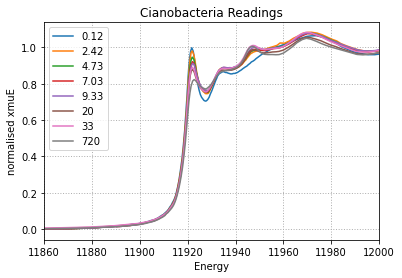

In [4]:
# https://vimeo.com/340216087 10:40 plot readings of sample 
# set group names
group_names = {'ozun':"0.12",'wtnk':"2.42", 'd_4_73':"4.73",
               'd_7_03':"7.03",'d_9_33':"9.33", 'qvxh':"20",'rjbc':"33",
               'lshy':"720",'hqlr':"Au Foil",'Au1_Cl':"Au1 Cl",
               'tscd':"Au3 Cl aq",'ixde':"Au hydroxide",'gcpx' :"Au cyanide",
               'nyux' :"Au thiocyanide",'qhxp':"Au sulphide",
               'Au_thiosulphate_aq':"Au thiosulphate aq",
               'ryzf':"Au thiomalate aq"}
# get the group keys for first 8 groups
group_keys = list(cianobacteria_project._athena_groups.keys())[0:8]


# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(cianobacteria_project, group_keys, group_names,
                              title = "Cianobacteria Readings",
                              xlimits = [11860,12000])

## Plot Standards
For comparison the next inetaction plots the standards. It is convinient to have a comprehensive library of standards, which can the be used for fingerprinting, principal components analyis, or linear combination fitting. 

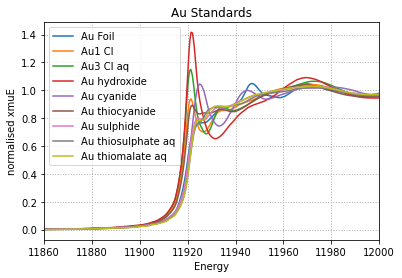

In [6]:
# https://vimeo.com/340216087 12:10 plot standards 
# get the group keys for first last 9 groups
group_keys = list(cianobacteria_project._athena_groups.keys())[8:17]


# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(cianobacteria_project, group_keys, group_names,
                              title = "Au Standards",
                              xlimits = [11860,12000])


## Compare initial and final reading to standards
Now we want to compare the earliest and last sample readings to the standards which are expected to be closer to them, this is comparing 0.12 ro Au Cl Aq and 720 to Au3 Cl Aq

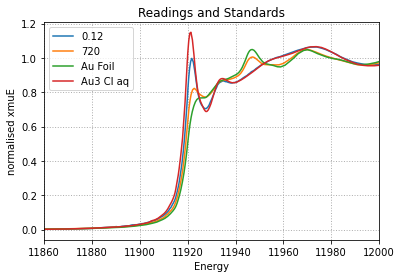

In [7]:
# https://vimeo.com/340216087 15:05 compare readings to standars 
group_keys = ['ozun', 'lshy','hqlr','tscd']

# plot mu vs flat normalised mu for selected groups
# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(cianobacteria_project, group_keys, group_names,
                              title = "Readings and Standards",
                              xlimits = [11860,12000])

to make it easier to see we plot the sample and standards separately

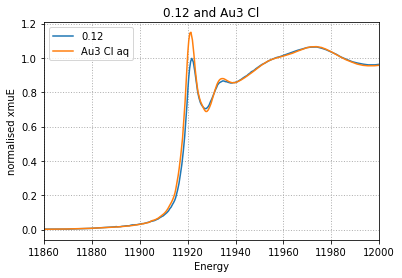

In [8]:
# https://vimeo.com/340216087 15:05 compare readings to standars 
# Earliest measure compared to Au3Cl
group_keys = ['ozun', 'tscd']

# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(cianobacteria_project, group_keys, group_names,
                              title = "0.12 and Au3 Cl",
                              xlimits = [11860,12000])

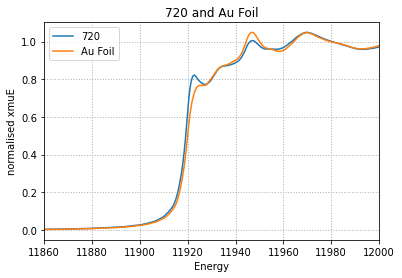

In [9]:
# https://vimeo.com/340216087 15:05 compare readings to standars 
# final measure compared to Au foil
group_keys = ['lshy','hqlr']

# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(cianobacteria_project, group_keys, group_names,
                              title = "720 and Au Foil",
                              xlimits = [11860,12000])

## Linear combination fitting
The linear combination fitting is performed by selecting one of the intermediate readings (e.g. 7.03), and create a list of standards to combine (e.g. the ones used before Au foil and Au3Cl).  


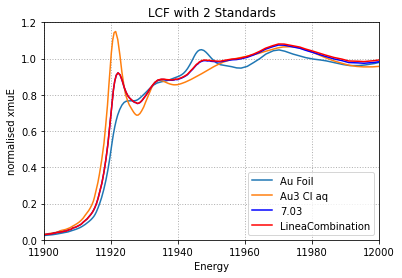

In [11]:
# https://vimeo.com/340216087 19:58 linear combination for inner state 
standard_keys = ['hqlr','tscd'] #Au Foil and Au3Cl
intermidate_state_key = 'd_7_03'

# get the intermediate group
mid_group = gr_0 = extract_athenagroup(cianobacteria_project._athena_groups[intermidate_state_key])
# recalculate normalisation
calc_with_defaults(mid_group)

# get the list of standard groups
components = {}
for group_key in standard_keys:
    components[group_key] = extract_athenagroup(cianobacteria_project._athena_groups[group_key])
    # recalculate normalisation
    calc_with_defaults(components[group_key])
    

comb = lincombo_fit(mid_group,list(components.values()),[0.5,0.5])

# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(cianobacteria_project, standard_keys, group_names,
                              title = "LCF with 2 Standards",
                              xlimits = [11900,12000], ylimits=[0,1.2])
plt.plot(mid_group.energy, mid_group.flat, label="7.03",color="blue")
plt.plot(comb.xdata, comb.ydata, label="LineaCombination",color="r")
plt.legend()

The match of linear combination and the reading are almost perfect but there is still a small difference towards the end. This can be better approximated by adding another component.

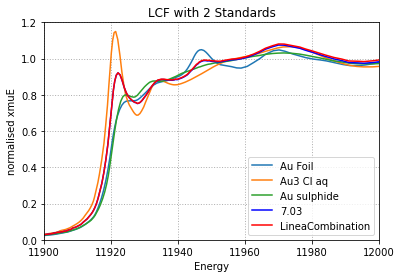

In [13]:
# https://vimeo.com/340216087 23:50 linear combination for inner state 
standard_keys = ['hqlr','tscd', 'qhxp'] #Au Foil, Au3Cl, and Au sulphide

# add Au Sulphide
components['qhxp'] = extract_athenagroup(cianobacteria_project._athena_groups['qhxp'])
calc_with_defaults(components['qhxp'])
    

comb = lincombo_fit(mid_group,list(components.values()),[0.333,0.333,0.333])

# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(cianobacteria_project, standard_keys, group_names,
                              title = "LCF with 2 Standards",
                              xlimits = [11900,12000], ylimits=[0,1.2])
plt.plot(mid_group.energy, mid_group.flat, label="7.03",color="blue")
plt.plot(comb.xdata, comb.ydata, label="LineaCombination",color="r")
plt.legend()

Video time 28:04